# 1. Library

In [1]:
#Initially forked from Bojan's kernel here: https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2242/code
#improvement using kernel from Nick Brook's kernel here: https://www.kaggle.com/nicapotato/bow-meta-text-and-dense-features-lgbm
#Used oof method from Faron's kernel here: https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867
#Used some text cleaning method from Muhammad Alfiansyah's kernel here: https://www.kaggle.com/muhammadalfiansyah/push-the-lgbm-v19
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from tqdm import tqdm

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from sklearn.metrics import mean_squared_error
from math import sqrt

NFOLDS = 5
SEED = 42
VALID = False
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))


/home/g492652607/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Preprocess

In [2]:
def preprocess_dataset(df):
    t1 = time.time()
    print("Loging and Filling Numerical Missing Values.....")
    df["price"] = np.log(df["price"]+0.001)
    df["price"].fillna(df.price.mean(),inplace=True)
    df["image_top_1"].fillna(-999,inplace=True)
    df['avg_days_up_user'].fillna(-999,inplace=True)
    df['avg_times_up_user'].fillna(-999,inplace=True)
    
    print("\nCreate Time Variables")
    df["Weekday"] = df['activation_date'].dt.weekday
    df["Day of Month"] = df['activation_date'].dt.day
    df.drop(["activation_date","image"],axis=1,inplace=True)
    
    print("PreProcessing completed.")    
    return df

def add_features(df):
    print("Combine new features")
    period_features = pd.read_csv('/home/g492652607/data/aggregated_features.csv')
    agg_features = pd.read_csv('/home/g492652607/data/agg_final.csv',index_col = "item_id")
    dfdex=df.index
    df = df.merge(period_features, how="left", on='user_id').set_index(dfdex)
    df = df.merge(agg_features, left_index = True, right_index = True)
    df.drop("user_id",axis=1, inplace=True)
    
    print("Adding features completed.")    
    return df

# 3. Feature engineering

In [3]:
def feature_engineering(df, training, categorical):
    print("target encoding...")
    agg_cols = ['region', 'city', 'parent_category_name', 'category_name',
                'image_top_1', 'user_type',"param_1", "param_2", "param_3"]
    for c in tqdm(agg_cols):
        gp = training.groupby(c)['deal_probability']
        mean = gp.mean()
        std  = gp.std()
        df[c + '_deal_probability_avg'] = df[c].map(mean)
        df[c + '_deal_probability_std'] = df[c].map(std)
    
    print("image_top_1 groupby...")
    gp = training.groupby('image_top_1')['price']
    mean = gp.mean()
    count = gp.size()
    df['image_top_1' + '_price_avg'] = df['image_top_1'].map(mean)
    df['image_top_1' + 'count'] = df['image_top_1'].map(count)
    
    print("LabelEncode Variables")
    lbl = preprocessing.LabelEncoder()
    for col in categorical:
        df[col].fillna('Unknown')
        df[col] = lbl.fit_transform(df[col].astype(str))
    
    print("feature_engineering completed.")
    return df

# 4. Tf_idf

In [4]:
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"

def text_feature(df, all_samples):
    print("\nText Features")
    # Meta Text Features
    textfeats = ["description", "title"]
    df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['title'] = df['title'].apply(lambda x: cleanName(x))
    df['description'] = df['description'].apply(lambda x: cleanName(x))
    all_samples["description"]   = all_samples["description"].apply(lambda x: cleanName(x))
    all_samples['title'] = all_samples['title'].apply(lambda x: cleanName(x))

    for cols in textfeats:
        df[cols] = df[cols].astype(str) 
        df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
        df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
        df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
        df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
        df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

    print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
    russian_stop = set(stopwords.words('russian'))

    tfidf_para = {
        "stop_words": russian_stop,
        "analyzer": 'word',
        "token_pattern": r'\w{1,}',
        "sublinear_tf": True,
        "dtype": np.float32,
        "norm": 'l2',
        #"min_df":5,
        #"max_df":.9,
        "smooth_idf":False
    }


    def get_col(col_name): return lambda x: x[col_name]
    ##I added to the max_features of the description. It did not change my score much but it may be worth investigating
    vectorizer = FeatureUnion([
            ('description',TfidfVectorizer(
                ngram_range=(1, 2),
                max_features=1000000,
                **tfidf_para,
                preprocessor=get_col('description'))),
            ('title',CountVectorizer(
                ngram_range=(1, 2),
                stop_words = russian_stop,
                max_features=1000000,
                preprocessor=get_col('title')))
        ])
    
    start_vect=time.time()
    vectorizer.fit(all_samples.to_dict('records'))
    ready_df = vectorizer.transform(df.to_dict('records'))
    tfvocab = vectorizer.get_feature_names()
    df.drop(textfeats, axis=1,inplace=True)
    print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))
    
    return df, ready_df, tfvocab

# 5. Oof_ridge

In [5]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


def oof_ridge(df, ready_df):
    print("oof ridge feature...")
    ridge_params = {'alpha':20.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

    #Ridge oof method from Faron's kernel
    #I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
    #It doesn't really add much to the score, but it does help lightgbm converge faster
    ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
    ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

    rms = sqrt(mean_squared_error(y, ridge_oof_train))
    print('Ridge OOF RMSE: {}'.format(rms))

    ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
    df['ridge_preds'] = ridge_preds
    
    print("oof_ridge completed.")
    return df

# 6. Data before modeling

In [6]:
def feature_combining(df, ready_df, tfvocab):
    print("feature combining...")
    # Combine Dense Features with Sparse Text Bag of Words Features
    X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
    testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
    tfvocab = df.columns.tolist() + tfvocab
    for shape in [X,testing]:
        print("{} Rows and {} Cols".format(*shape.shape))
    print("Feature Names Length: ",len(tfvocab))
    return X, testing, tfvocab

# 7. Modeling

In [7]:
def modeling(X, tfvocab, categorical, testing):
    print("\nModeling Stage...")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)
    
    print("Light Gradient Boosting Regressor")
    lgbm_params =  {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        # 'max_depth': 15,
        'num_leaves': 250,
        'feature_fraction': 0.65,
        'bagging_fraction': 0.85,
        # 'bagging_freq': 5,
        'learning_rate': 0.02,
        'verbose': 0
    }  

    if VALID == True:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.10, random_state=23)
        
        # LGBM Dataset Formatting 
        lgtrain = lgb.Dataset(X_train, y_train,
                        feature_name=tfvocab,
                        categorical_feature = categorical)
        lgvalid = lgb.Dataset(X_valid, y_valid,
                        feature_name=tfvocab,
                        categorical_feature = categorical)
        del X, X_train; gc.collect()
    
        # Go Go Go
        lgb_clf = lgb.train(
            lgbm_params,
            lgtrain,
            num_boost_round=n_rounds,
            valid_sets=[lgtrain, lgvalid],
            valid_names=['train','valid'],
            early_stopping_rounds=50,
            verbose_eval=100
        )
        print("Model Evaluation Stage")
        print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
        del X_valid ; gc.collect()

    else:
        # LGBM Dataset Formatting 
        lgtrain = lgb.Dataset(X, y,
                        feature_name=tfvocab,
                        categorical_feature = categorical)
        del X; gc.collect()
        # Go Go Go
        lgb_clf = lgb.train(
            lgbm_params,
            lgtrain,
            num_boost_round=910,
            verbose_eval=100
        )

    # Feature Importance Plot
    f, ax = plt.subplots(figsize=[7,10])
    lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.savefig('feature_import.png',bbox_inches="tight")

    print("Model Evaluation Stage")
    lgpred = lgb_clf.predict(testing)
    
    print("Modeling completed.")
    return lgpred

In [8]:
def load_active():
    print("load active data...")
    use_cols = ['title', 'description']
    train_active = pd.read_csv('/home/g492652607/data/train_active.csv', usecols=use_cols, nrows=7000000)
    test_active = pd.read_csv('/home/g492652607/data/test_active.csv', usecols=use_cols, nrows=7000000)
    all_samples = pd.concat([
        train_active,
        test_active
    ])
    del test_active, train_active
    gc.collect()
    print("load active data completed.")
    return all_samples

# 8. Main


Data Load Stage
Train shape: 1503424 Rows, 17 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns
Combine new features
Adding features completed.
Loging and Filling Numerical Missing Values.....

Create Time Variables


  0%|          | 0/9 [00:00<?, ?it/s]

PreProcessing completed.
target encoding...


100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


image_top_1 groupby...
LabelEncode Variables
feature_engineering completed.
load active data...
load active data completed.

Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 59.88 Minutes
oof ridge feature...

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.22987161646167023
oof_ridge completed.
feature combining...
1503424 Rows and 2000056 Cols
508438 Rows and 2000056 Cols
Feature Names Length:  2000056

Modeling Stage...
Light Gradient Boosting Regressor


/home/g492652607/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


/home/g492652607/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Modeling completed.
Notebook Runtime: 127.33 Minutes


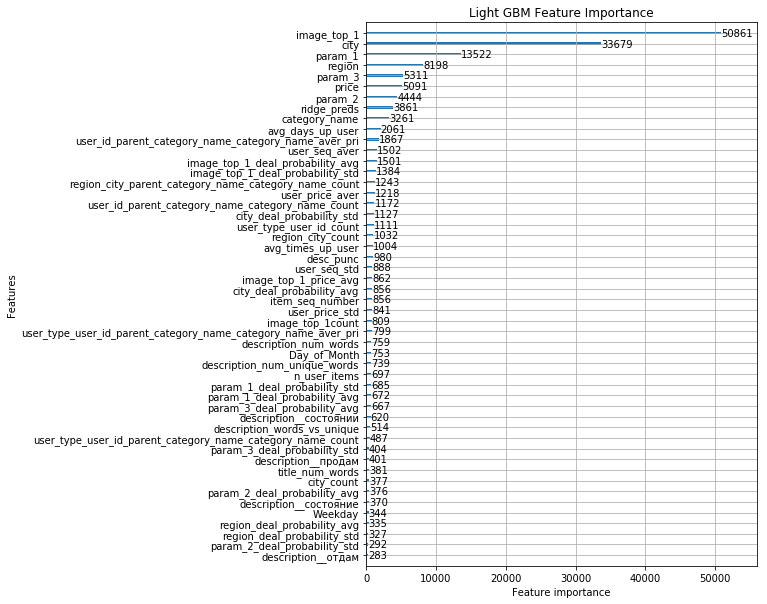

In [9]:
print("\nData Load Stage")
debug= 0
if debug:
    training = pd.read_csv('/home/g492652607/data/train.csv', index_col = "item_id", parse_dates = ["activation_date"], nrows=50000)
    testing = pd.read_csv('/home/g492652607/data/test.csv', index_col = "item_id", parse_dates = ["activation_date"], nrows=20000)
else:
    training = pd.read_csv('/home/g492652607/data/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
    testing = pd.read_csv('/home/g492652607/data/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testdex = testing.index
ntrain = training.shape[0]
ntest = testing.shape[0]
y = training.deal_probability.copy()
# Create Validation Index and Remove Dead Variables
#training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
#validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
df.drop("deal_probability",axis=1, inplace=True)
del testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)
categorical = ["region","city","parent_category_name",
                "category_name","user_type","image_top_1","param_1","param_2","param_3"]

df = add_features(df)
df = preprocess_dataset(df)
df = feature_engineering(df, training, categorical)
del training; gc.collect()
all_samples = load_active()
df, ready_df, tfvocab = text_feature(df, all_samples)
del all_samples; gc.collect()
df = oof_ridge(df, ready_df)
X, testing, tfvocab = feature_combining(df, ready_df, tfvocab)
del ready_df; gc.collect()
lgpred = modeling(X, tfvocab, categorical, testing)

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))